# Energy Meter Examples

## Monsoon Power Monitor

*NOTE*: the **monsoon.py** tool is required to collect data from the power monitor.

Instructions on how to install it can be found here:

https://github.com/ARM-software/lisa/wiki/Energy-Meters-Requirements#monsoon-power-monitor.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-05-10 16:00:38,824 INFO    : root         : Using LISA logging configuration:
2017-05-10 16:00:38,826 INFO    : root         :   /data/Code/lisa/logging.conf


#### Import required modules

In [2]:
# Generate plots inline
%matplotlib inline

import os

# Support to access the remote target
import devlib
from env import TestEnv

# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Ramp

2017-05-10 16:00:39,606 WARNING : EnergyModel  : Unusual max capacity (1023), overriding capacity_scale


## Target Configuration
The target configuration is used to describe and configure your test environment.
You can find more details in **examples/utils/testenv_example.ipynb**.

In [3]:
# Let's assume the monsoon binary is installed in the following path
MONSOON_BIN = os.path.join(os.getenv('LISA_HOME'), 'tools', 'scripts', 'monsoon.py')

In [4]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"    : 'android',
    "board"       : 'wahoo',
    
    # Android tools
    "ANDROID_HOME" : "/home/derkling/Code/lisa/tools/android-sdk-linux",
    
    # Folder where all the results will be collected
    "results_dir" : "EnergyMeter_Monsoon",

    # Define devlib modules to load
    "modules" : ["cpufreq"], # Required by rt-app calibration
    "exclude_modules" : [ 'hwmon' ],

    # Energy Meters Configuration for ARM Energy Probe
    "emeter" : {
        "instrument" : "monsoon",
        "conf" : {
            'monsoon_bin' : MONSOON_BIN,
        },
    },
    
    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    
    # Comment this line to calibrate RTApp in your own platform
    # "rtapp-calib" :  {"0": 360, "1": 142, "2": 138, "3": 352, "4": 352, "5": 353},
}

In [5]:
# Once powered the Monsoon Power Monitor does not enable the output voltage.
# Since the devlib's API expects that the device is powered and available for
# an ADB connection, let's manually power on the device before initializing the TestEnv

# Power on the device
!$MONSOON_BIN --device /dev/ttyACM1 --voltage 4.2

# Enable USB passthrough to be able to connect the device
!$MONSOON_BIN --usbpassthrough on

In [6]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2017-05-10 16:00:46,506 INFO    : TestEnv      : Using base path: /data/Code/lisa
2017-05-10 16:00:46,509 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-05-10 16:00:46,510 INFO    : TestEnv      : External tools using:
2017-05-10 16:00:46,511 INFO    : TestEnv      :    ANDROID_HOME: /home/derkling/Code/lisa/tools/android-sdk-linux
2017-05-10 16:00:46,512 INFO    : TestEnv      :    CATAPULT_HOME: /data/Code/lisa/tools/catapult
2017-05-10 16:00:46,514 INFO    : TestEnv      : Loading board:
2017-05-10 16:00:46,515 INFO    : TestEnv      :    /data/Code/lisa/libs/utils/platforms/wahoo.json
2017-05-10 16:00:46,517 INFO    : TestEnv      : Devlib modules to load: [u'bl', u'cpuidle', u'cpufreq']
2017-05-10 16:00:46,519 INFO    : TestEnv      : Connecting Android target [DEFAULT]
2017-05-10 16:00:46,520 INFO    : TestEnv      : Connection settings:
2017-05-10 16:00:46,521 INFO    : TestEnv      :    None
2017-05-10 16:00:46,683 INFO    : android      : ls command

In [8]:
# If your device support charge via USB, let's disable it in order
# to read the overall power consumption from the main output channel

# For example, this is the API for a Pixel phone:
te.target.write_value('/sys/class/power_supply/battery/charging_enabled', 0)

## Workload Execution and Power Consumptions Samping

Detailed information on RTApp can be found in **examples/wlgen/rtapp_example.ipynb**.

Each **EnergyMeter** derived class has two main methods: **reset** and **report**.
 - The **reset** method will reset the energy meter and start sampling from channels specified in the target configuration. <br>
 - The **report** method will stop capture and will retrieve the energy consumption data. This returns an EnergyReport composed of the measured channels energy and the report file. Each of the samples can also be obtained, as you can see below.

In [9]:
# Create and RTApp RAMP task
rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
rtapp.conf(kind='profile',
           params={
                'ramp' : Ramp(
                    start_pct =  60,
                    end_pct   =  20,
                    delta_pct =   5,
                    time_s    =   0.5).get()
          })

# EnergyMeter Start
te.emeter.reset()

rtapp.run(out_dir=te.res_dir)

# EnergyMeter Stop and samples collection
nrg_report = te.emeter.report(te.res_dir)

2017-05-10 16:01:02,532 INFO    : Workload     : Setup new workload ramp
2017-05-10 16:01:02,639 INFO    : Workload     : Workload duration defined by longest task
2017-05-10 16:01:02,641 INFO    : Workload     : Default policy: SCHED_OTHER
2017-05-10 16:01:02,643 INFO    : Workload     : ------------------------
2017-05-10 16:01:02,644 INFO    : Workload     : task [ramp], sched: using default policy
2017-05-10 16:01:02,646 INFO    : Workload     :  | calibration CPU: 4
2017-05-10 16:01:02,647 INFO    : Workload     :  | loops count: 1
2017-05-10 16:01:02,648 INFO    : Workload     : + phase_000001: duration 0.500000 [s] (5 loops)
2017-05-10 16:01:02,650 INFO    : Workload     : |  period   100000 [us], duty_cycle  60 %
2017-05-10 16:01:02,651 INFO    : Workload     : |  run_time  60000 [us], sleep_time  40000 [us]
2017-05-10 16:01:02,652 INFO    : Workload     : + phase_000002: duration 0.500000 [s] (5 loops)
2017-05-10 16:01:02,653 INFO    : Workload     : |  period   100000 [us], d

In [10]:
logging.info("Collected data:")
!tree $te.res_dir

2017-05-10 16:01:07,581 INFO    : root         : Collected data:


/data/Code/lisa/results/EnergyMeter_Monsoon
├── energy.json
├── output.log
├── ramp_00.json
├── rt-app-ramp-0.log
└── samples.csv

0 directories, 5 files


## Power Measurements Data

In [11]:
logging.info("Measured channels energy:")
logging.info("%s", nrg_report.channels)

2017-05-10 16:01:08,994 INFO    : root         : Measured channels energy:
2017-05-10 16:01:08,996 INFO    : root         : {'output': 0.20335059300000002, 'USB': 0.0021446260000000002}


In [12]:
logging.info("Generated energy file:")
logging.info("  %s", nrg_report.report_file)
!cat $nrg_report.report_file

2017-05-10 16:01:09,538 INFO    : root         : Generated energy file:
2017-05-10 16:01:09,540 INFO    : root         :   /data/Code/lisa/results/EnergyMeter_Monsoon/energy.json


{
    "USB": 0.0021446260000000002, 
    "output": 0.20335059300000002
}

In [13]:
logging.info("Samples collected for the Output and Battery channels (only first 10)")
samples_file = os.path.join(te.res_dir, 'samples.csv')
!head $samples_file

2017-05-10 16:01:09,996 INFO    : root         : Samples collected for the Output and Battery channels (only first 10)


In [14]:
logging.info("DataFrame of collected samples (only first 5)")
nrg_report.data_frame.head()

2017-05-10 16:01:10,595 INFO    : root         : DataFrame of collected samples (only first 5)


,output,USB
,power,power
0.000,0.081740,0.000463
0.002,0.084564,0.000463
0.004,0.082917,0.000455
0.006,0.081374,0.000461
0.008,0.075255,0.000464


2017-05-10 16:01:16,701 INFO    : root         : Plot of collected power samples


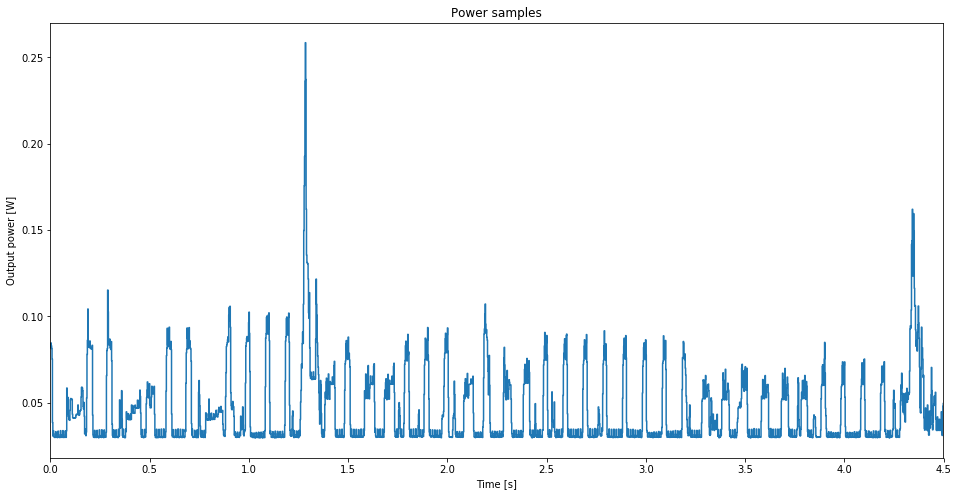

In [16]:
logging.info("Plot of collected power samples")
axes = nrg_report.data_frame[('output', 'power')].plot(
                    figsize=(16,8), drawstyle='steps-post');
axes.set_title('Power samples');
axes.set_xlabel('Time [s]');
axes.set_ylabel('Output power [W]');

In [17]:
logging.info("Plot of collected power samples")
nrg_report.data_frame.describe(percentiles=[0.90, 0.95, 0.99]).T

2017-05-10 16:01:18,356 INFO    : root         : Plot of collected power samples


,,count,mean,std,min,50%,90%,95%,99%,max
output,power,2250.0,0.045218,0.022001,0.029505,0.034054,0.076411,0.085983,0.110465,0.258452
USB,power,2250.0,0.000477,0.000046,0.000449,0.000466,0.000478,0.000503,0.000703,0.000734


2017-05-10 16:01:19,645 INFO    : root         : Power distribution


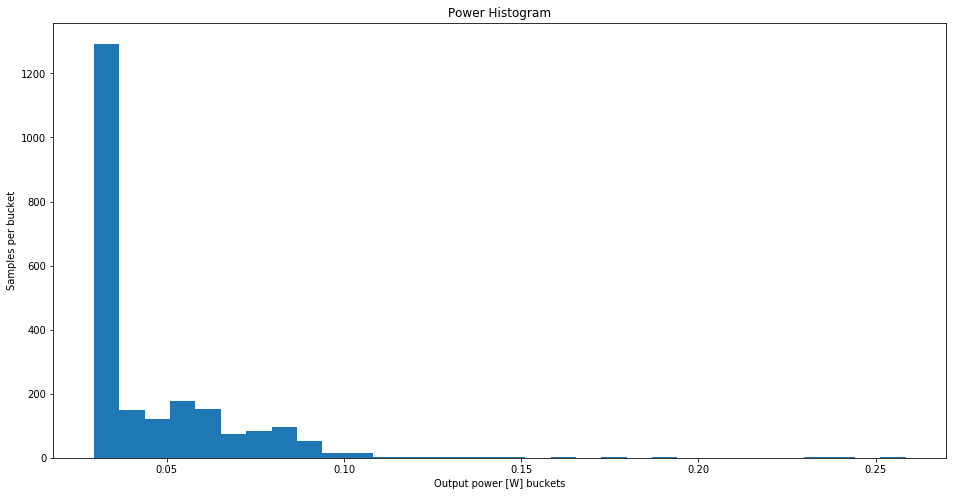

In [18]:
logging.info("Power distribution")
axes = nrg_report.data_frame[('output', 'power')].plot(
                    kind='hist', bins=32,
                    figsize=(16,8));
axes.set_title('Power Histogram');
axes.set_xlabel('Output power [W] buckets');
axes.set_ylabel('Samples per bucket');